# Testing and creation notebook for Metrics

### Import libraries

In [1]:
import os, sys
from typing import List, Tuple
from collections.abc import Callable
import time
import datetime as dt
from tqdm.notebook import tqdm

In [2]:
import pandas as pd
import numpy as np

In [3]:
from scipy.stats import wasserstein_distance

In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [17]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, DenseDataLoader

from torch_geometric.nn import GraphConv, global_add_pool, DenseGraphConv, dense_diff_pool
import torch.nn.functional as F
from torch.nn import NLLLoss
from torch.utils.data import SubsetRandomSampler

from torch_geometric.utils import to_dense_adj
from torch_geometric.transforms import ToDense

In [42]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

In [7]:
# Update rc parameters
SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 16

rcParams['font.family'] = 'serif'
rcParams['font.size'] = SMALL_SIZE
rcParams['axes.titlesize'] = SMALL_SIZE
rcParams['axes.labelsize'] = MEDIUM_SIZE
rcParams['xtick.labelsize'] = SMALL_SIZE
rcParams['ytick.labelsize'] = SMALL_SIZE
rcParams['legend.fontsize'] = SMALL_SIZE
rcParams['figure.titlesize'] = LARGE_SIZE

rcParams['figure.figsize'] = [8.3, 5.1]

rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#F5F5F5'
rcParams['axes.axisbelow'] = True
rcParams['grid.linestyle'] = ':'

In [8]:
from ipywidgets import interact, interact_manual, FloatSlider

In [54]:
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../src/'))

from src.utils import load_dataset
from src.models import BaselineGNN
from src.train import train
from src.metrics import evaluate_accuracy, TrainingMetrics, TestingMetrics, compute_predictions, Metrics

CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

## Figures

Setting up a baseline model just for testing purposes

In [32]:
dataset_train, dataset_test = \
        load_dataset(connectivity='wasserstein', test_size=.2, seed=42,
                dense=model.is_dense(), verbose=0)

In [108]:
model = BaselineGNN(2, 16, 43)

metrics = TrainingMetrics()
    
kfold = KFold(n_splits=3, shuffle=True)

for fold, (I_train, I_valid) in enumerate(kfold.split(dataset_train)):

        metrics.set_run(fold)

        model.reset()

        sampler_train = SubsetRandomSampler(I_train)
        sampler_valid = SubsetRandomSampler(I_valid)

        loader_train_args = dict(dataset=dataset_train, batch_size=8, sampler=sampler_train)
        loader_valid_args = dict(dataset=dataset_train, batch_size=8, sampler=sampler_valid)

        loader_train = DenseDataLoader(**loader_train_args) if model.is_dense() \
                else DataLoader(**loader_train_args)
        loader_valid = DenseDataLoader(**loader_valid_args) if model.is_dense() \
                else DataLoader(**loader_valid_args)
                
        train(model, loader_train, loader_valid, metrics)

100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


In [37]:
loader_test_args = dict(dataset=dataset_test, batch_size=len(dataset_test))
    
loader_test = DenseDataLoader(**loader_test_args) if model.is_dense() \
    else DataLoader(**loader_test_args)

Analyzing the stored data to generate plots

In [101]:
test_metrics = TestingMetrics(epoch=25)
test_metrics.compute_metrics(model, loader_test)

In [107]:
class TrainingMetrics(Metrics):

    def __init__(self):
        
        super(TrainingMetrics, self).__init__()
        self.run = 0
    
    def log_metric(self, metric: str, value: float, step: int = 0):
        
        self.storage.append(dict(metric=metric, value=value, step=step, run=self.run))
    
    def incr_run(self):
        
        self.run += 1
    
    def set_run(self, run: int = 0):
        
        self.run = run
    
    def send_log(self, timestamp: dt.datetime):
    
        df = pd.DataFrame(self.storage)
        
        mean = df.groupby(['metric', 'step']).value.mean().reset_index()
        
        for _, feature in mean.iterrows():
            mlflow.log_metric(feature.metric + ' - avg', feature.value, feature.step)
        
        std = df.groupby(['metric', 'step']).value.std().reset_index()
        
        for _, feature in std.iterrows():
            mlflow.log_metric(feature.metric + ' - std', feature.value, feature.step)
            
    def plot(self, fpath: str):
        pass

In [111]:
df = pd.DataFrame(metrics.storage)
df

,metric,value,step,run
0,Loss - training,18.963058,0,0
1,Accuracy - training,0.574468,0,0
2,Accuracy - validation,0.291667,0,0
3,Loss - training,26.744211,1,0
4,Accuracy - training,0.553191,1,0
...,...,...,...,...
220,Accuracy - training,0.645833,23,2
221,Accuracy - validation,0.608696,23,2
222,Loss - training,3.385343,24,2
223,Accuracy - training,0.687500,24,2


In [118]:
[m for m in df.metric.unique() if 'acc' in m.lower()]

['Accuracy - training', 'Accuracy - validation']

Text(0.5, 0.98, 'Training loss and accuracy')

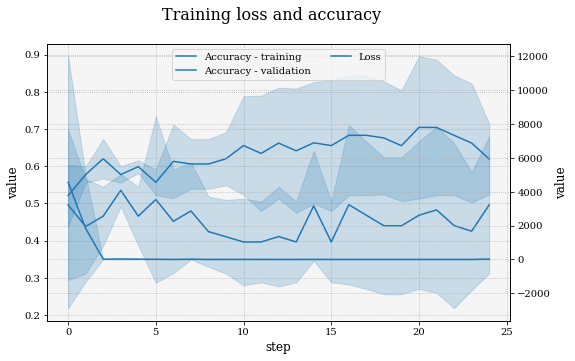

In [130]:
accs = [m for m in df.metric.unique() if 'acc' in m.lower()]
loss = [m for m in df.metric.unique() if 'loss' in m.lower()]

fig = plt.figure()

ax_acc = fig.add_subplot(111)

for acc in accs:
    sns.lineplot(data=df[df.metric.isin([acc])], x='step', y='value', hue='metric', estimator='mean', ci='sd', 
                 legend=False, label=acc, ax=ax_acc)

ax_loss = ax_acc.twinx()

sns.lineplot(data=df[df.metric.isin(loss)], x='step', y='value', hue='metric', estimator='mean', ci='sd', 
             legend=False, label='Loss',ax=ax_loss)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1), bbox_transform=ax_acc.transAxes, ncol=2)

plt.suptitle("Training loss and accuracy")
